
# Portfolio Analysis Notebook

This notebook replicates the logic from a Streamlit-based portfolio analysis application. 
It walks through each component step-by-step, with explanations, tables, and plots.

---

**Note:** This version is adapted for Jupyter notebooks. UI elements like buttons or input forms have been removed. Instead, values are assigned directly for demonstration purposes.


In [33]:
%matplotlib inline

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize

# Import core functions from project modules (ensure the project is in PYTHONPATH or use relative imports)
from app.config.config import (
    HISTORICAL_PERIOD_DAYS, BENCHMARK_TICKER,
    PORTFOLIO_EVOLUTION_YEARS, TARGET_MARKET_BETA,
    NUMBER_OF_PORTFOLIOS)
from app.visualization.visuals import (
    create_pie_chart, plot_historical_prices, plot_daily_returns,
    plot_portfolio_returns, plot_portfolio_evolution, plot_sharpe_ratio_scatter,
    plot_efficient_frontier
)
from app.analysis.portfolio_analyzer import PortfolioAnalyzer



## Step 1: Define Portfolio Inputs

We'll simulate the user input that was previously collected through Streamlit inputs.


In [34]:

# Simulated user portfolio (example)
amount = 10000  # Total investment amount

# User's tickers and their allocations (as percentages)
ticker_percentage = {
    'AAPL': 0.4,
    'MSFT': 0.3,
    'GOOGL': 0.3
}

tickers = list(ticker_percentage.keys())
weights = list(ticker_percentage.values())
num_tickers = len(tickers)


## Step 2: Define Date Range

We define the historical period over which we want to analyze the portfolio.
This is typically a fixed number of days (e.g., 365), retrieved from the configuration.
It is used to fetch historical price data for the selected stocks.

In [35]:

end_date = datetime.today().date()
start_date = end_date - timedelta(days=HISTORICAL_PERIOD_DAYS)
print(f"Date Range: {start_date} to {end_date}")


Date Range: 2024-07-01 to 2025-07-01


## Step 3: Load Historical Prices

We fetch historical price data for the user-selected stocks over the defined time range.
This data will be used to compute returns and other statistical metrics necessary for optimization and analysis.

In [36]:
def get_historical_prices(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

    if data.empty:
        print("Yahoo Finance returned empty data. Please check ticker symbols and try again.")
        return None

    # Handle MultiIndex data (whether single or multiple tickers)
    if isinstance(data.columns, pd.MultiIndex):
        try:
            adj_close = data.xs('Adj Close', level=1, axis=1)
            return adj_close
        except KeyError:
            print("No 'Adj Close' data found in MultiIndex columns.")
            return None

    # Handle flat DataFrame (only happens for some single tickers)
    if 'Adj Close' in data.columns:
        return pd.DataFrame(data['Adj Close'])

    print("Unexpected data format from Yahoo Finance.")
    return None

In [37]:

prices = get_historical_prices(tickers, start_date, end_date)
prices.head()

[*********************100%***********************]  3 of 3 completed


Ticker,MSFT,GOOGL,AAPL
Date,,,
2024-07-01,453.254883,182.107849,215.741043
2024-07-02,455.785492,184.347015,219.244659
2024-07-03,457.264160,184.924194,220.518692
2024-07-05,464.002502,189.681168,225.286407
2024-07-08,462.692566,188.118729,226.759521


## Step 4: Plot Historical Prices

This plot visually represents how each stock's price has changed over the past year.
It helps understand the volatility and trend of individual assets within the portfolio.

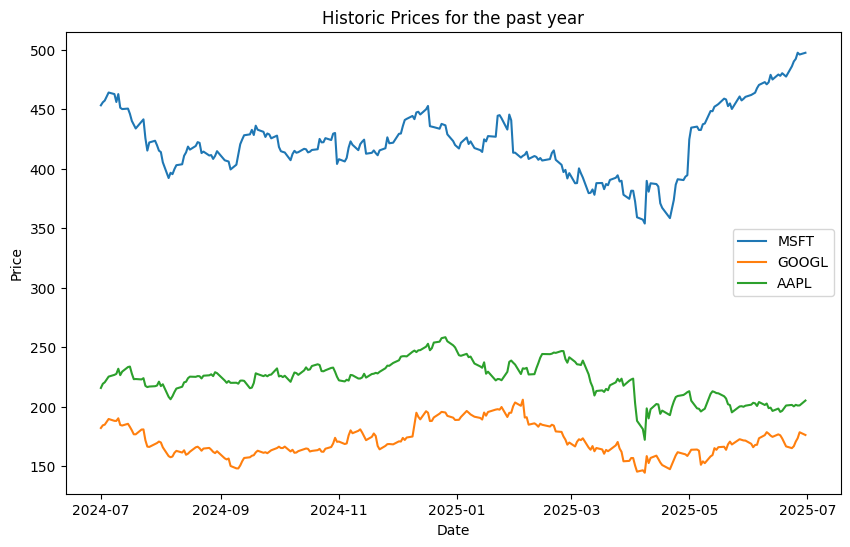

In [38]:

plot_historical_prices(prices)


## Step 5: Calculate Daily Returns

We calculate the daily percentage returns of each stock using their historical prices.
These returns are essential for computing the portfolio return, risk, Sharpe ratio, beta, and for optimization techniques.

In [39]:
def get_daily_returns(price):
    """Use the `pct_change` function to calculate daily returns of closing prices for each column"""
    returns = price.pct_change()
    return returns

In [40]:

daily_returns = get_daily_returns(prices)
daily_returns.head()


Ticker,MSFT,GOOGL,AAPL
Date,,,
2024-07-01,NaN,NaN,NaN
2024-07-02,0.005583,0.012296,0.016240
2024-07-03,0.003244,0.003131,0.005811
2024-07-05,0.014736,0.025724,0.021620
2024-07-08,-0.002823,-0.008237,0.006539


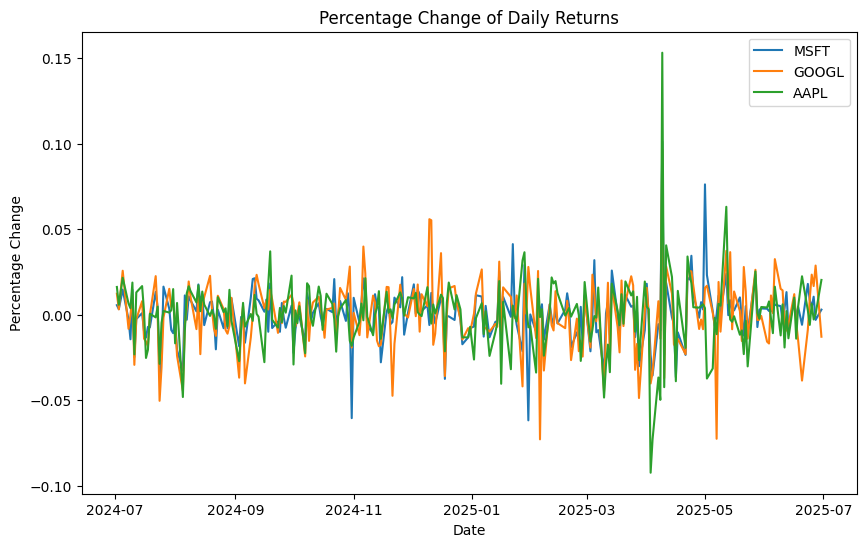

In [41]:

plot_daily_returns(daily_returns)


## Step 6: Portfolio Daily Returns

Here, we calculate the daily return of the entire portfolio using the user-defined weights.
This helps assess the overall portfolio's performance and is used for further analysis.

In [42]:
def get_portfolio_returns(weights, daily_returns):
    """Use the `dot` function to multiply the weights by each stock's daily return to get the portfolio daily return"""
    portfolio_returns = daily_returns.dot(weights)
    return portfolio_returns

In [43]:

port_daily_return = get_portfolio_returns(weights, daily_returns)
port_daily_return.head()


Date
2024-07-01         NaN
2024-07-02    0.010794
2024-07-03    0.003980
2024-07-05    0.020098
2024-07-08   -0.001639
dtype: float64

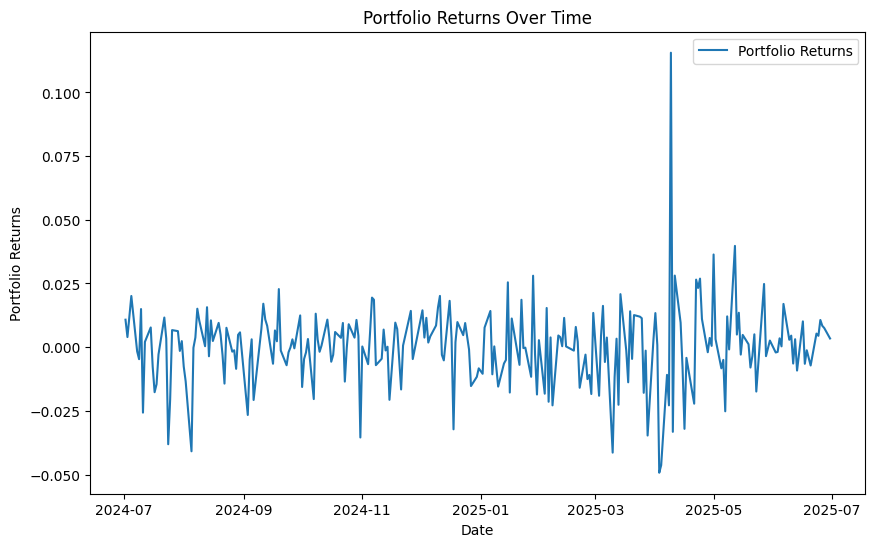

In [44]:

plot_portfolio_returns(port_daily_return)


## Step 7: Beta Coefficients


In this section, we are calculating the **Beta coefficient** for each stock in our portfolio with respect to a benchmark index (like the S&P 500). Beta is a measure of how much a stock moves in relation to the market. It helps us understand the **systematic risk** of each asset.

---

### **What Is the Overall Goal?**

We want to:
1. Get the benchmark index’s historical price data.
2. Convert that price data into **daily returns**.
3. Compare our portfolio's stock returns to the benchmark returns.
4. **Calculate the Beta** for each stock — this tells us how "risky" each stock is compared to the market.

---

In [45]:
def get_benchmark_data(start_date, end_date):
    """Get benchmark data for beta calculations"""
    benchmark_prices = get_historical_prices(BENCHMARK_TICKER, start_date, end_date)
    
    if benchmark_prices is None:
        print("Benchmark prices could not be retrieved.")
        return None

    benchmark_daily_returns = get_daily_returns(benchmark_prices)

    if benchmark_daily_returns is None or benchmark_daily_returns.empty:
        print("Benchmark daily returns could not be computed.")
        return None

    return benchmark_daily_returns.iloc[:, 0]

In [46]:
def calculate_beta(daily_returns, benchmark_returns):
    """Calculate Beta coefficient for each ticker to benchmark, SP500"""
    beta_list = {}
    
    # Iterate over each asset in the portfolio
    for ticker in daily_returns:
        # Calculate covariance between asset returns and benchmark returns
        covariance = daily_returns[ticker].cov(benchmark_returns)
        
        # Calculate variance of benchmark returns
        variance = benchmark_returns.var()
        
        # Calculate beta coefficient
        beta = covariance / variance
        
        # Store beta value in the dictionary
        beta_list[ticker] = beta
    
    # Create a Series from the dictionary
    beta_series = pd.Series(beta_list, name='Beta')
    
    return beta_series

In [47]:

benchmark_daily_returns = get_benchmark_data(start_date, end_date)
betas = calculate_beta(daily_returns, benchmark_daily_returns)
betas


[*********************100%***********************]  1 of 1 completed


MSFT     0.970007
GOOGL    1.053711
AAPL     1.238058
Name: Beta, dtype: float64

## Step 8: Beta Weights

Using the beta values, we compute weights inversely proportional to beta.
This strategy gives lower weights to volatile stocks and higher weights to more stable ones.

In [48]:
def calculate_beta_weights(data):
    """Calculate New Portfolio Weights Based on Stock Betas"""
    if isinstance(data, pd.Series):
        # If input is a Series, create a DataFrame with one column
        df = pd.DataFrame(data, columns=['Beta'])
    else:
        # If input is already a DataFrame, use it directly
        df = data

    beta_weights = {}
    target_market_beta = TARGET_MARKET_BETA
    sum_of_all_stock_betas = df['Beta'].sum()
    
    for index, row in df.iterrows():
        numerator = target_market_beta - row['Beta']
        denominator = sum_of_all_stock_betas - row['Beta']
        stock_weight = numerator / denominator
        beta_weights[index] = stock_weight
        
    beta_weights_df = pd.DataFrame.from_dict(beta_weights, orient='index', columns=['Weight'])
    beta_weights_df_normalized = beta_weights_df['Weight'] / beta_weights_df['Weight'].sum()
    
    return beta_weights_df_normalized

In [49]:

beta_weight = calculate_beta_weights(betas)
beta_weight


MSFT    -0.101553
GOOGL    0.188753
AAPL     0.912800
Name: Weight, dtype: float64

## Step 9: Risk Parity Weights

We compute risk parity weights so that each asset contributes equally to the overall portfolio risk.
This method is commonly used to build balanced portfolios where no single asset dominates the risk.

In [50]:
def calculate_risk_parity_weights(returns):
    """Risk Parity: invest such a way that every asset we have in the portfolio has the same risk contribution"""
    # Calculate asset volatilities
    asset_volatility = returns.std(axis=0)

    # Calculate asset risk contributions
    asset_risk_contribution = asset_volatility / asset_volatility.sum()

    # Determine target risk allocation (e.g., equal risk)
    target_risk_allocation = 1 / len(asset_volatility)

    # Calculate weights based on risk contributions
    weights = target_risk_allocation / asset_risk_contribution

    # Normalize weights to sum to 1
    weights /= weights.sum()

    return weights

In [51]:

risk_parity_weights = calculate_risk_parity_weights(daily_returns)
risk_parity_weights


Ticker
MSFT     0.386583
GOOGL    0.306979
AAPL     0.306437
dtype: float64

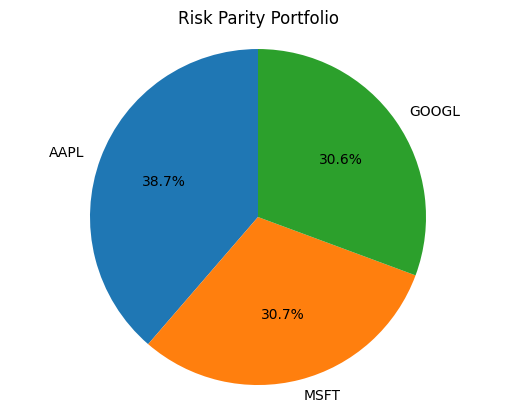

In [52]:

create_pie_chart(risk_parity_weights, tickers, 'Risk Parity Portfolio')


## Step 10: Analyze Strategies

We initialize a PortfolioAnalyzer object which is used to simulate and evaluate different portfolio strategies.
It helps us analyze the return evolution and total gains for various allocation techniques over a fixed time period.

In [53]:

analyzer = PortfolioAnalyzer(tickers)


### Analyze User Strategy

We simulate how the portfolio would have performed over the last 10 years using the original user-defined weights.
This serves as the baseline to compare other strategies.

[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


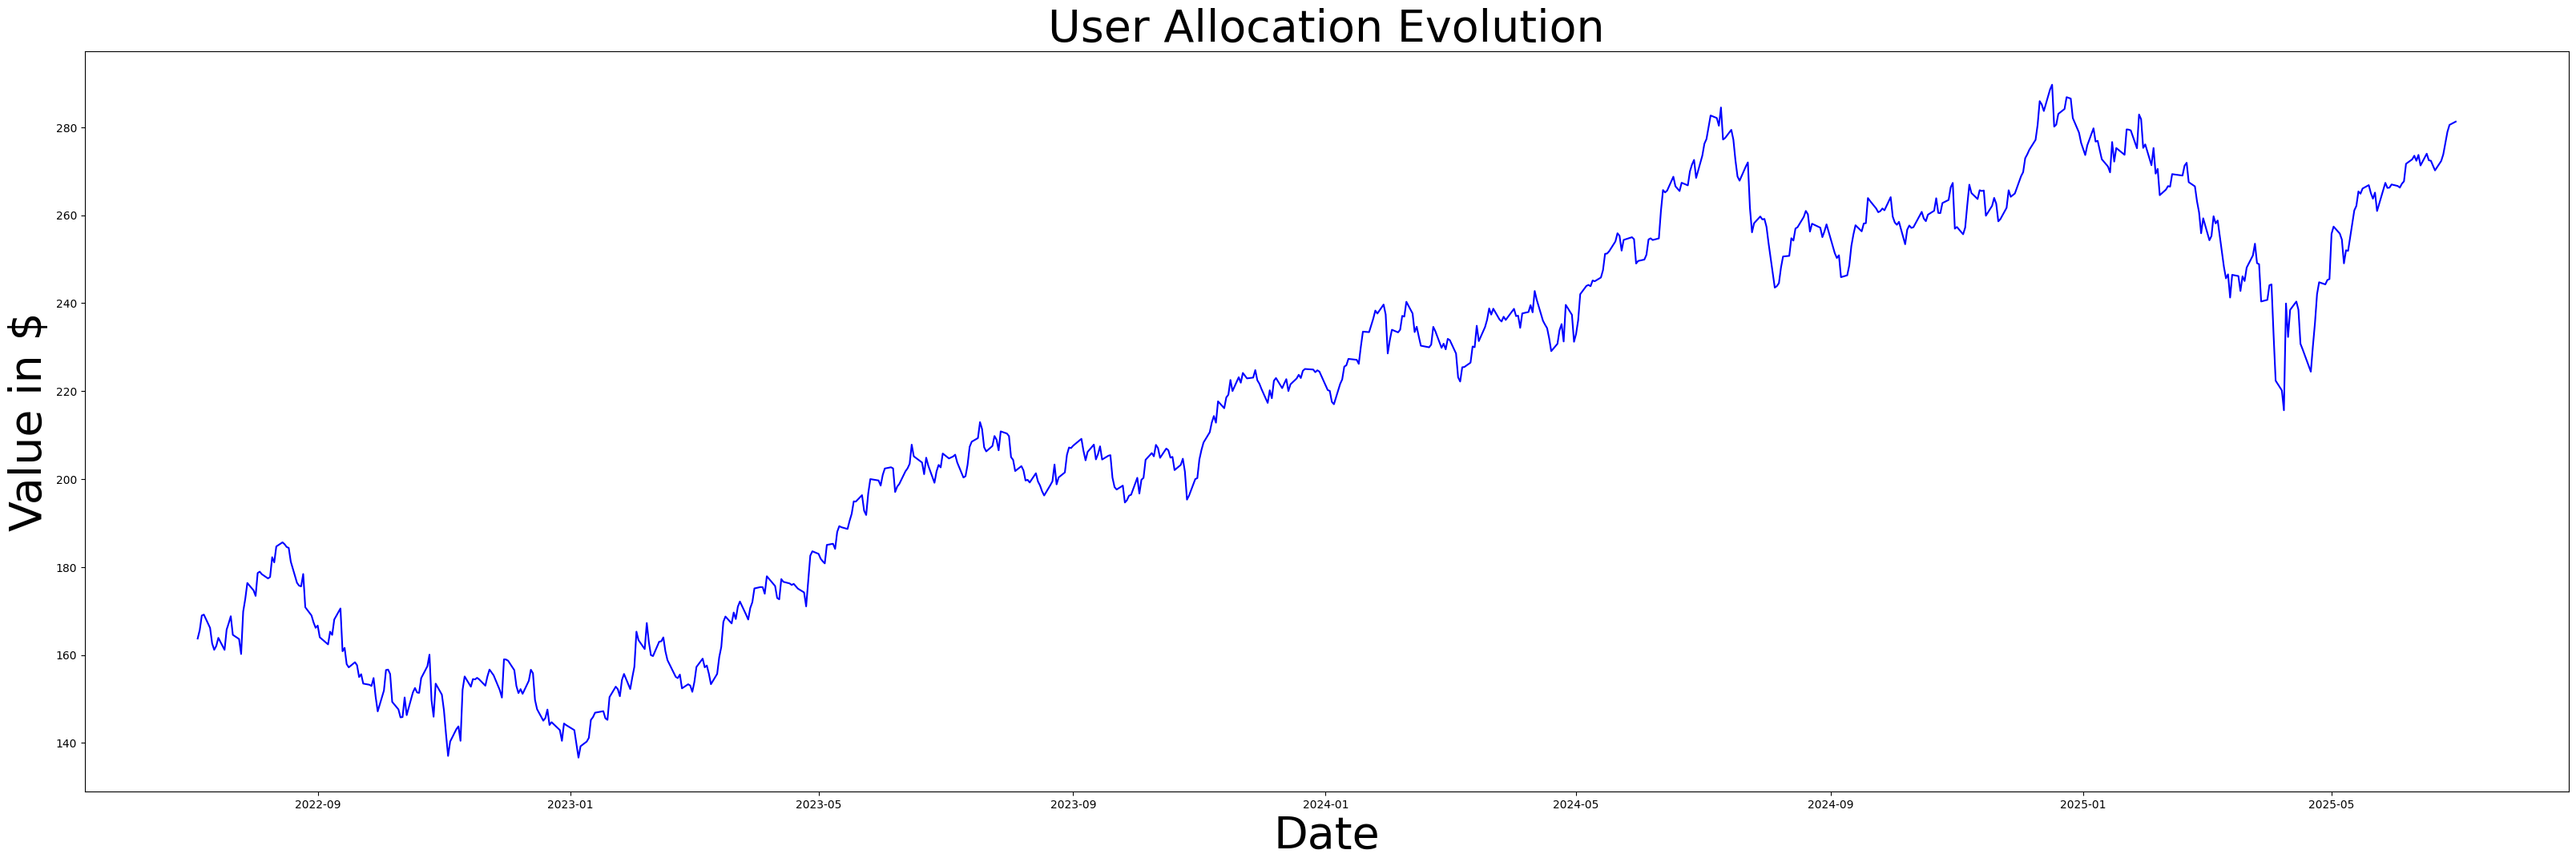

Total Return: 71.78%


In [54]:

user_value, user_return = analyzer.analyze_strategy('User', weights, PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(user_value, "User Allocation Evolution")
print(f"Total Return: {user_return:.2%}")


### Analyze Risk Parity Strategy

We evaluate how a risk parity-weighted portfolio would perform over time.
Risk parity aims for more diversified risk allocation and often yields more stable returns.

[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


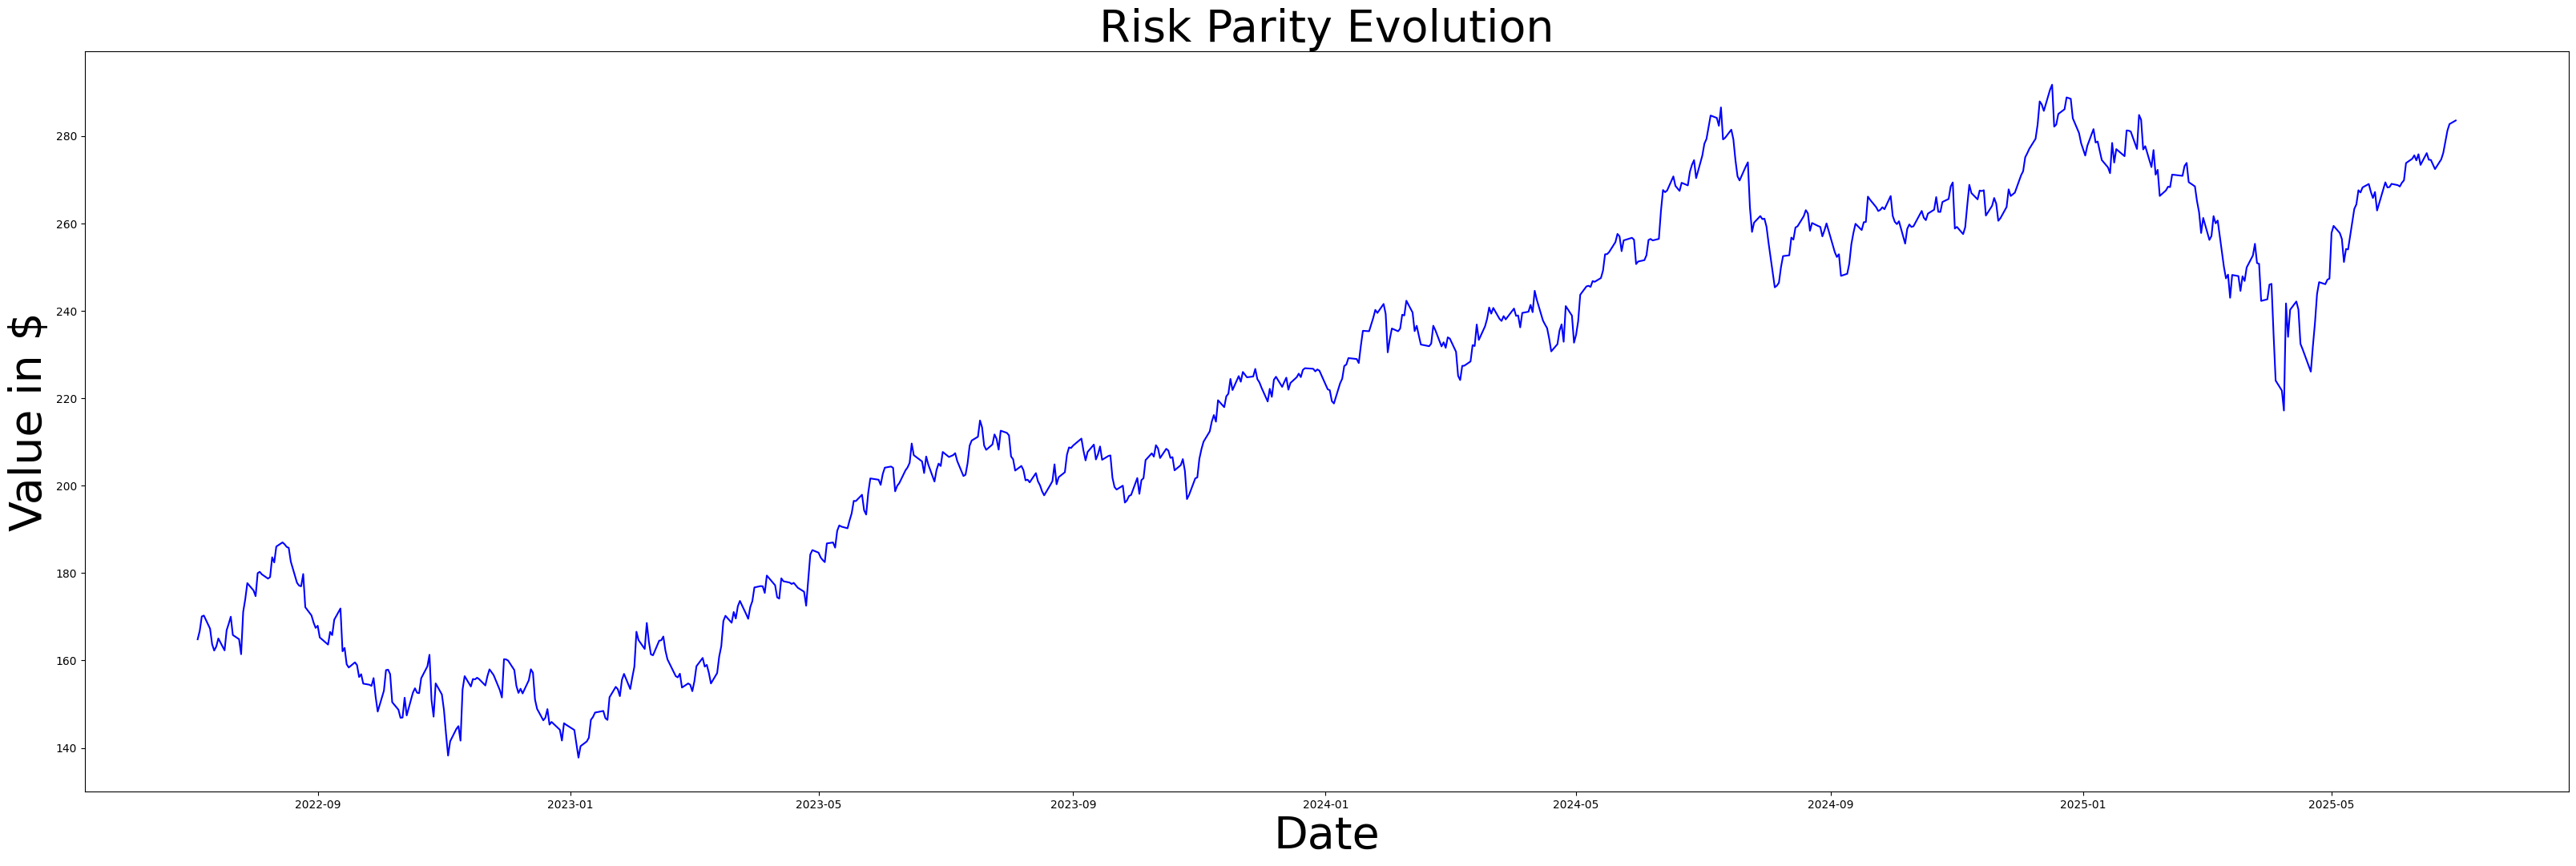

Total Return: 72.00%


In [55]:

rp_value, rp_return = analyzer.analyze_strategy('Risk Parity', risk_parity_weights, PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(rp_value, "Risk Parity Evolution")
print(f"Total Return: {rp_return:.2%}")


### Analyze Beta Weight Strategy

We test the beta-weighted strategy where less weight is given to stocks with high volatility.
This can result in a more stable portfolio that is less sensitive to market swings.

[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


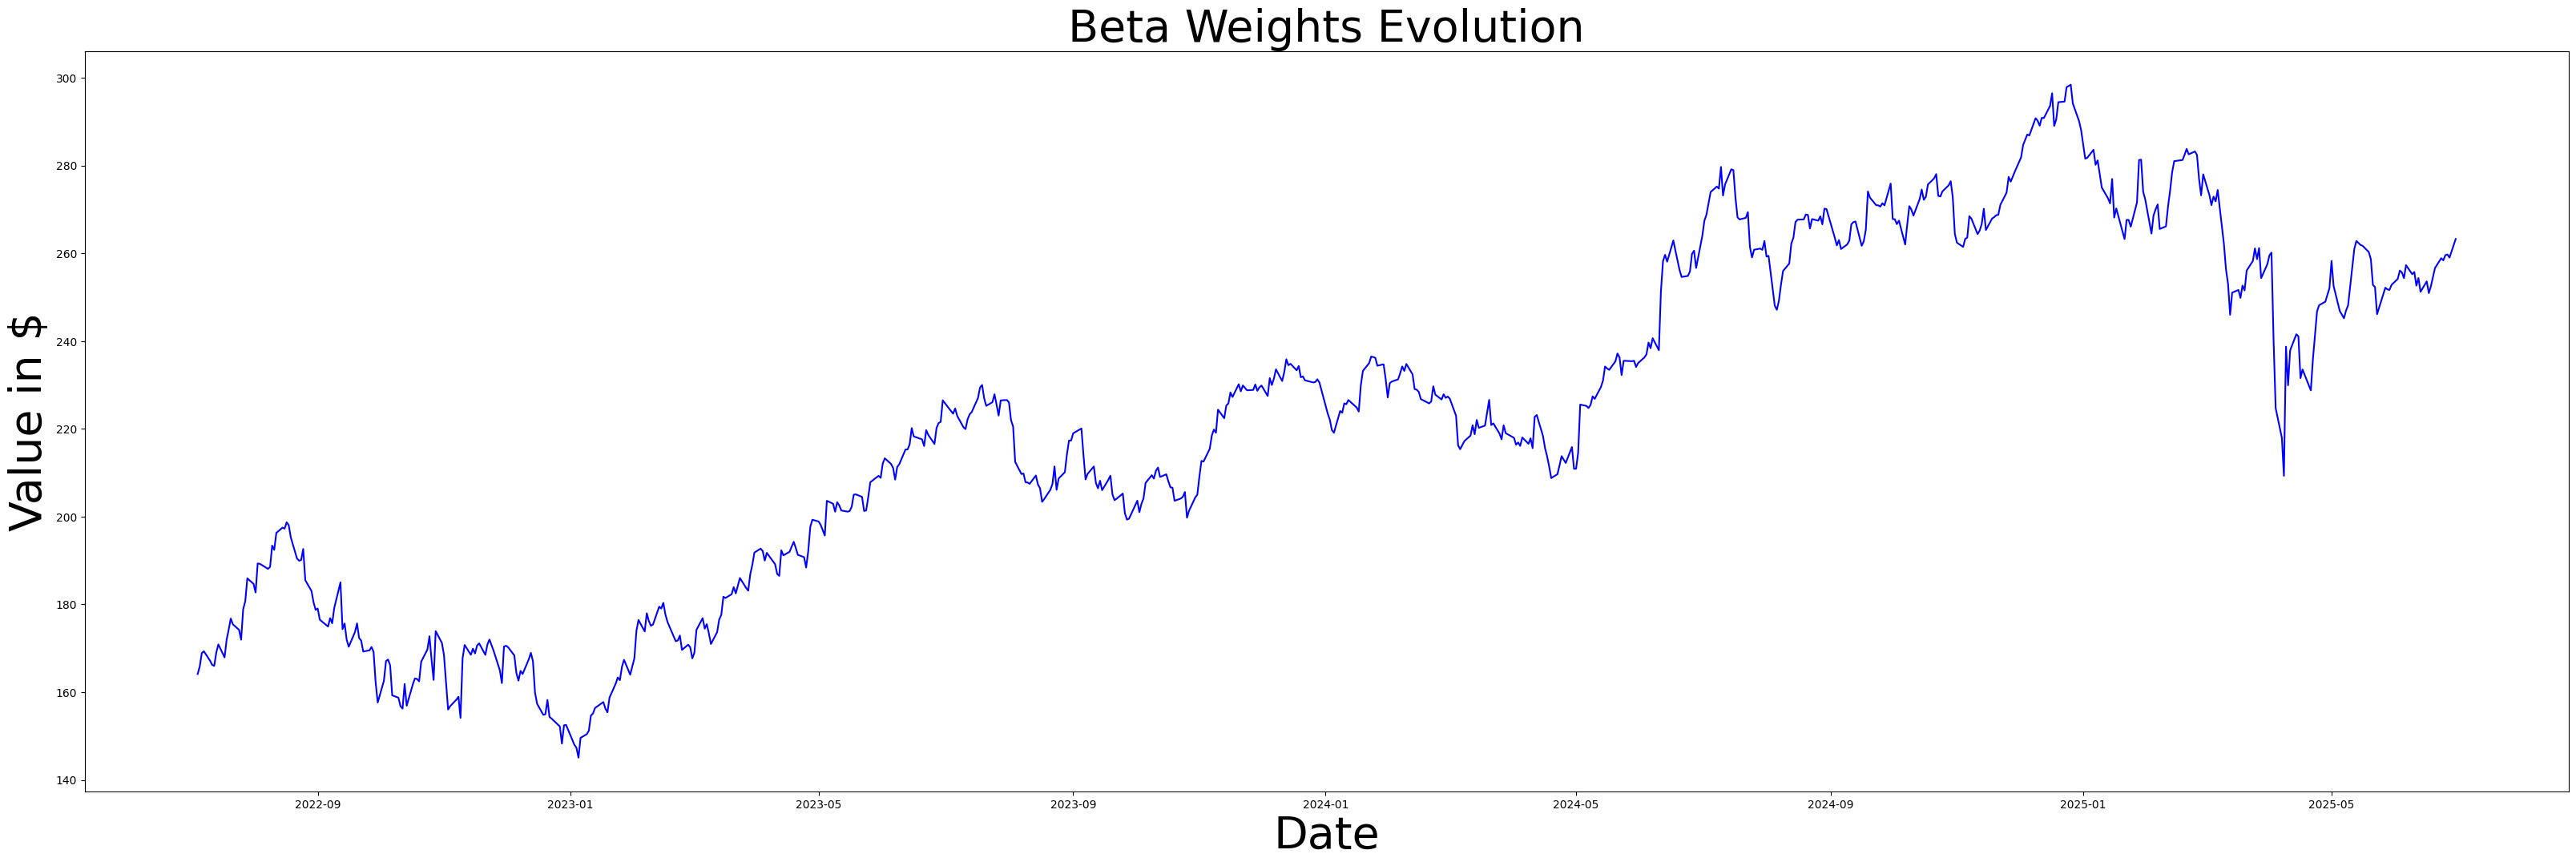

Total Return: 60.40%


In [56]:

beta_value, beta_return = analyzer.analyze_strategy('Beta', beta_weight, PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(beta_value, "Beta Weights Evolution")
print(f"Total Return: {beta_return:.2%}")


## Step 11: Sharpe Ratio Optimization

We run a simulation to generate random portfolio weights and compute the Sharpe Ratio (return/risk) for each.
The portfolio with the highest Sharpe Ratio is selected as optimal under this criterion.

In [57]:
def calculate_sharpe_ratio_optimization(prices, num_tickers):
    """Calculate optimal portfolio weights using Sharpe ratio optimization"""
    returns_marco = prices/(prices.shift(1))
    returns_marco.dropna(inplace=True)
    logreturns = np.log(returns_marco)
    meanlog = logreturns.mean()
    no_porfolio = NUMBER_OF_PORTFOLIOS
    test_weight = np.zeros((no_porfolio, num_tickers))
    sigma = logreturns.cov()
    test_return = np.zeros(no_porfolio)
    test_volatility = np.zeros(no_porfolio)
    sharpratio = np.zeros(no_porfolio)
    
    for k in range(no_porfolio):
        random_weight = np.array(np.random.random(num_tickers))
        random_weight = random_weight/sum(random_weight)
        test_weight[k,:] = random_weight
        #log returns
        test_return[k] = np.sum(meanlog * random_weight) 
        #volatility
        test_volatility[k] = np.sqrt(np.dot(random_weight.T, np.dot(sigma, random_weight)))
        #sharp ratio
        sharpratio[k] = test_return[k]/test_volatility[k]
    
    max_sharpratio = sharpratio.argmax()
    sharpratio_weight = test_weight[max_sharpratio,:]
    
    return {
        'test_volatility': test_volatility,
        'test_return': test_return,
        'sharpratio': sharpratio,
        'max_sharpratio': max_sharpratio,
        'sharpratio_weight': sharpratio_weight,
        'meanlog': meanlog,
        'sigma': sigma
    }

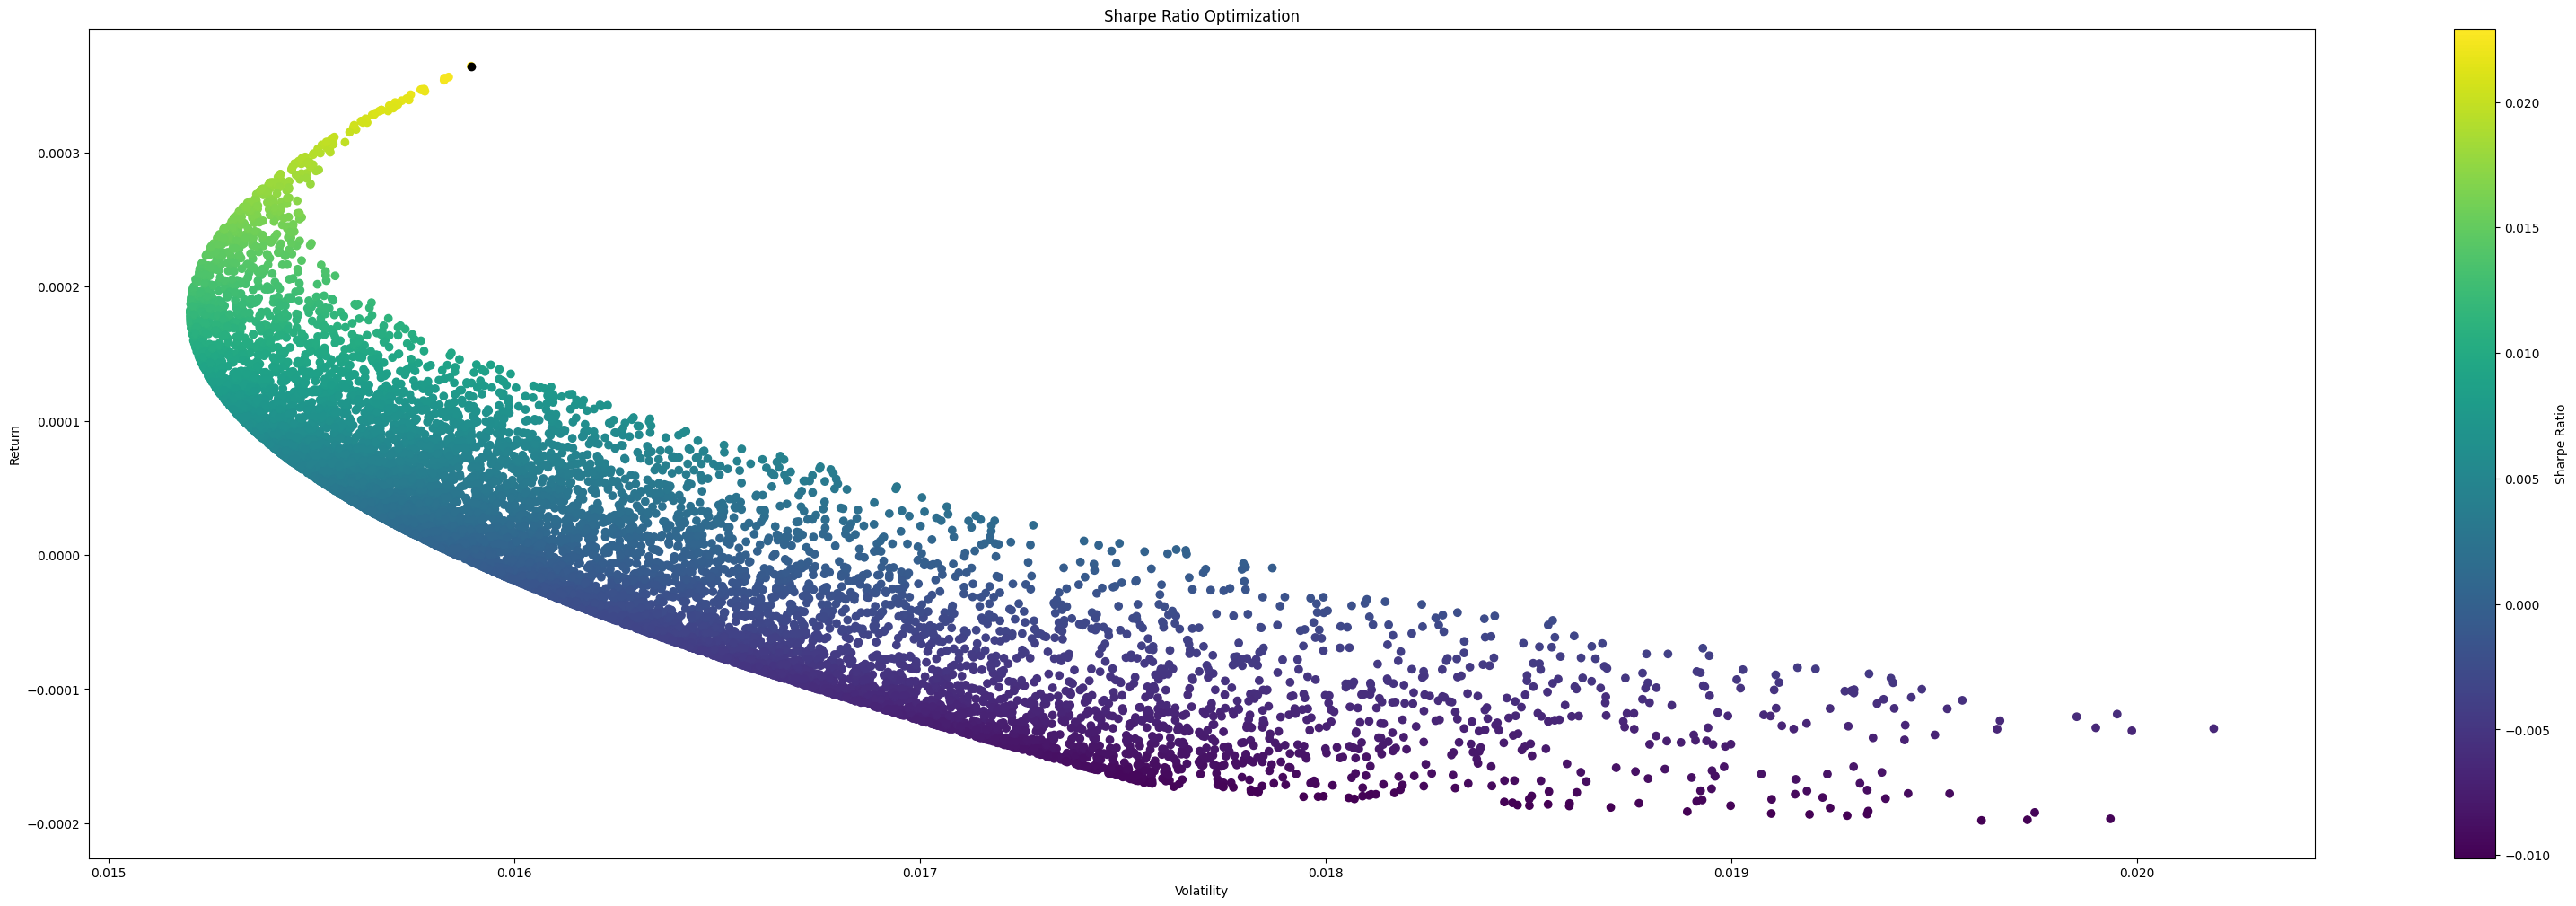

In [58]:

sharpe_data = calculate_sharpe_ratio_optimization(prices, num_tickers)
plot_sharpe_ratio_scatter(
    sharpe_data['test_volatility'], 
    sharpe_data['test_return'], 
    sharpe_data['sharpratio'], 
    sharpe_data['max_sharpratio']
)


[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


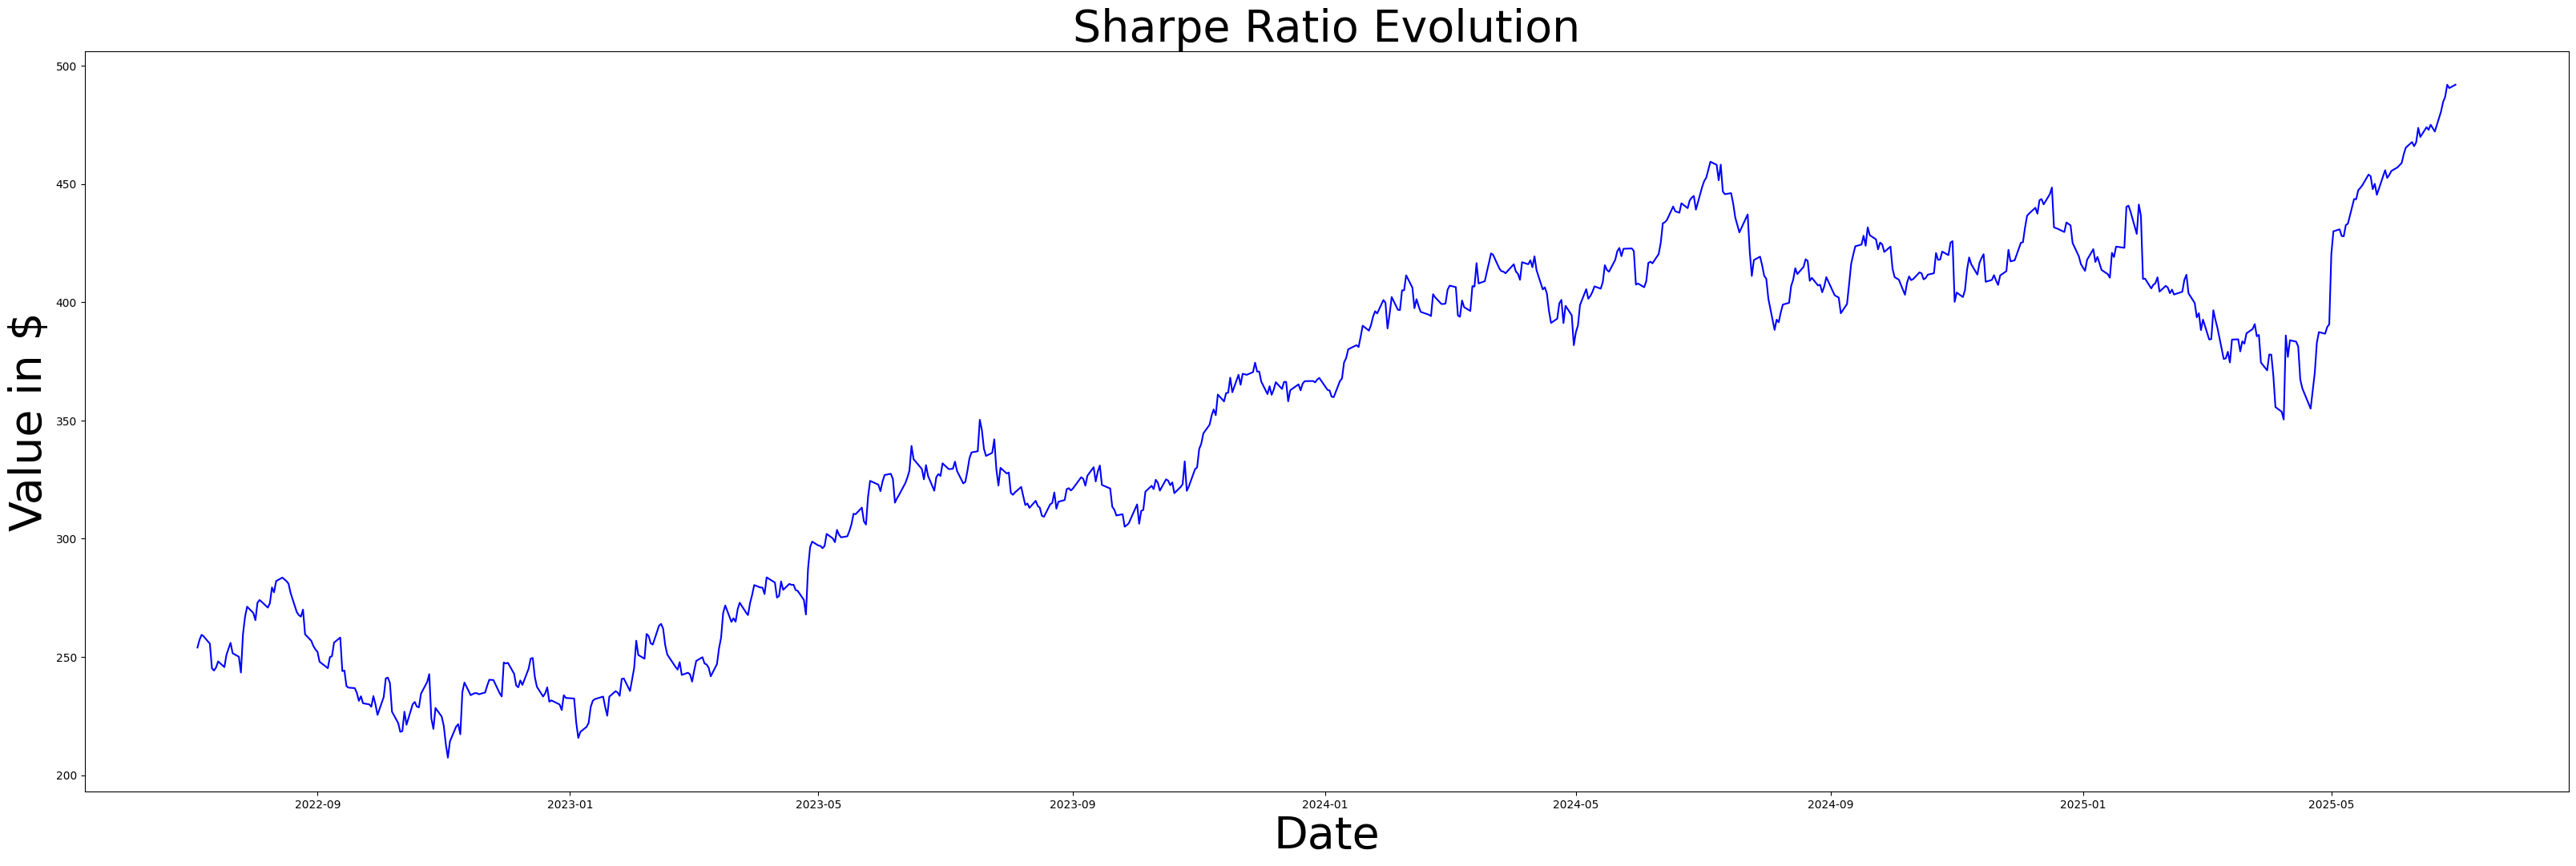

Total Return: 93.72%


In [59]:

sr_value, sr_return = analyzer.analyze_strategy('Sharp Ratio', sharpe_data['sharpratio_weight'], PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(sr_value, "Sharpe Ratio Evolution")
print(f"Total Return: {sr_return:.2%}")


## Step 12: Markowitz Optimization

We use Modern Portfolio Theory to calculate the 'efficient frontier' and determine the portfolio with the maximum Sharpe ratio.
This method helps identify the best trade-off between risk and return.

In [60]:
def calculate_markowitz_optimization(meanlog, sigma, num_tickers, test_return):
    """Calculate Markowitz optimal portfolio"""
    def negative_sharpratio(random_weight):
        random_weights = np.array(random_weight)
        R = np.sum(meanlog*random_weights)
        V = np.sqrt(np.dot(random_weight.T, np.dot(sigma, random_weights)))
        SR = R/V
        return -SR
    
    def checksumtoone(random_weight):
        return np.sum(random_weight)-1
    
    w_0 = [1/num_tickers for _ in range(num_tickers)]
    bounds = [(0,1) for _ in range(num_tickers)]
    constraints = ({'type':'eq','fun':checksumtoone})
    optimal_weight = minimize(negative_sharpratio, w_0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    # Calculate efficient frontier
    returns = np.linspace(0, max(test_return), 50)
    optimal_volatility = []  
    
    def minmizevolatility(random_weight):
        random_weights = np.array(random_weight)
        V = np.sqrt(np.dot(random_weight.T, np.dot(sigma, random_weights)))
        return V
    
    def getreturn(w):
        w = np.array(w)
        R = np.sum(meanlog*w)
        return R

    for r in returns:
        #find best volatility
        constraints = ({'type':'eq','fun':checksumtoone},{'type':'eq','fun': lambda random_weight: getreturn(random_weight)- r})
        optimal = minimize(minmizevolatility, w_0, method='SLSQP', bounds=bounds, constraints=constraints)
        optimal_volatility.append(optimal['fun'])
    
    return {
        'optimal_weight': optimal_weight,
        'returns': returns,
        'optimal_volatility': optimal_volatility
    }

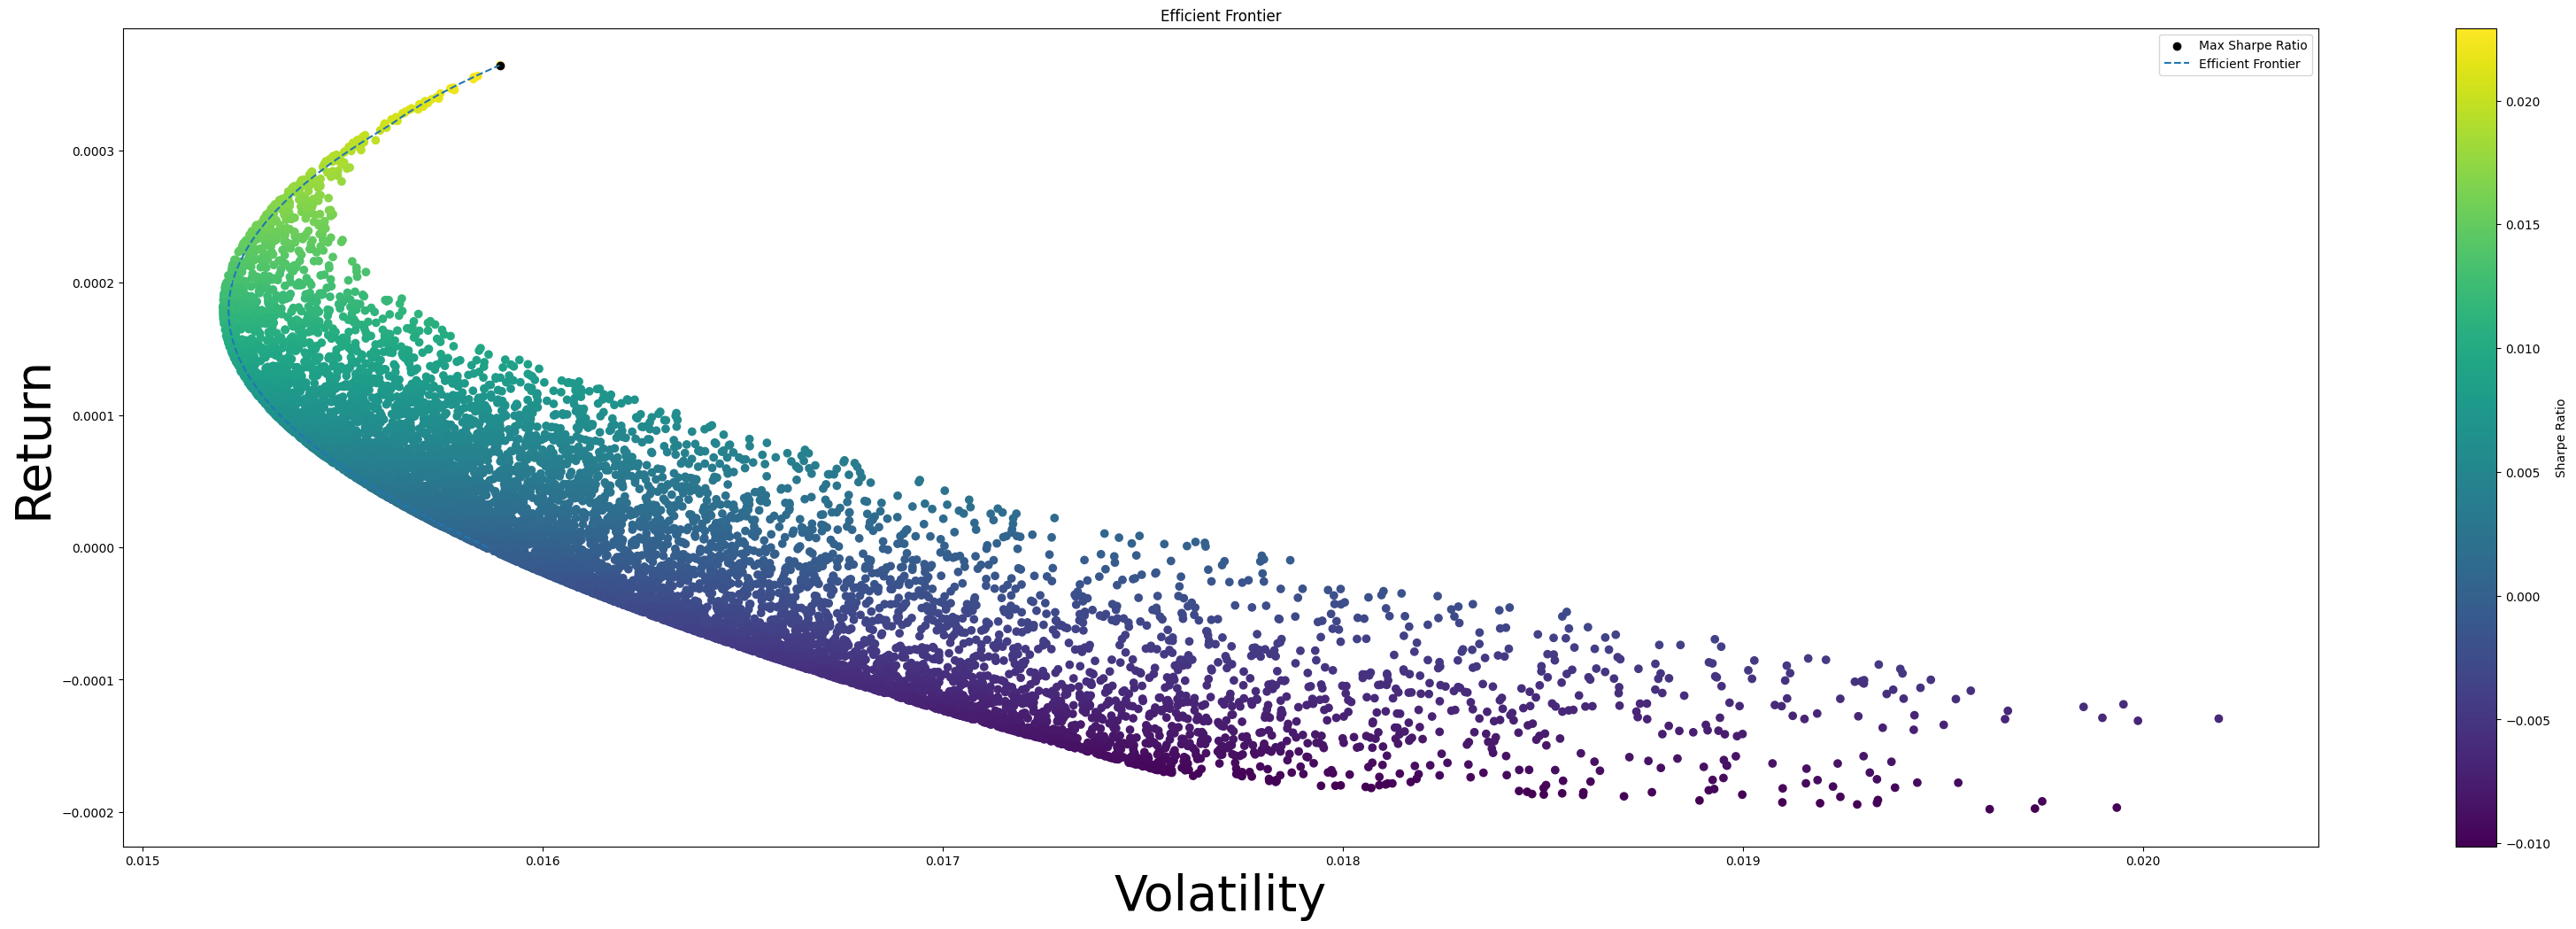

In [61]:

markowitz_data = calculate_markowitz_optimization(
    sharpe_data['meanlog'], 
    sharpe_data['sigma'], 
    num_tickers, 
    sharpe_data['test_return']
)
plot_efficient_frontier(
    sharpe_data['test_volatility'],
    sharpe_data['test_return'],
    sharpe_data['sharpratio'],
    sharpe_data['max_sharpratio'],
    markowitz_data['optimal_volatility'],
    markowitz_data['returns']
)


[*********************100%***********************]  3 of 3 completed
d:\WORK_DIRECTORY\Roboport\app\analysis\portfolio_analyzer.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = (portfolio_value['Profit Close'][-1]/portfolio_value['Profit Close'][0])-1


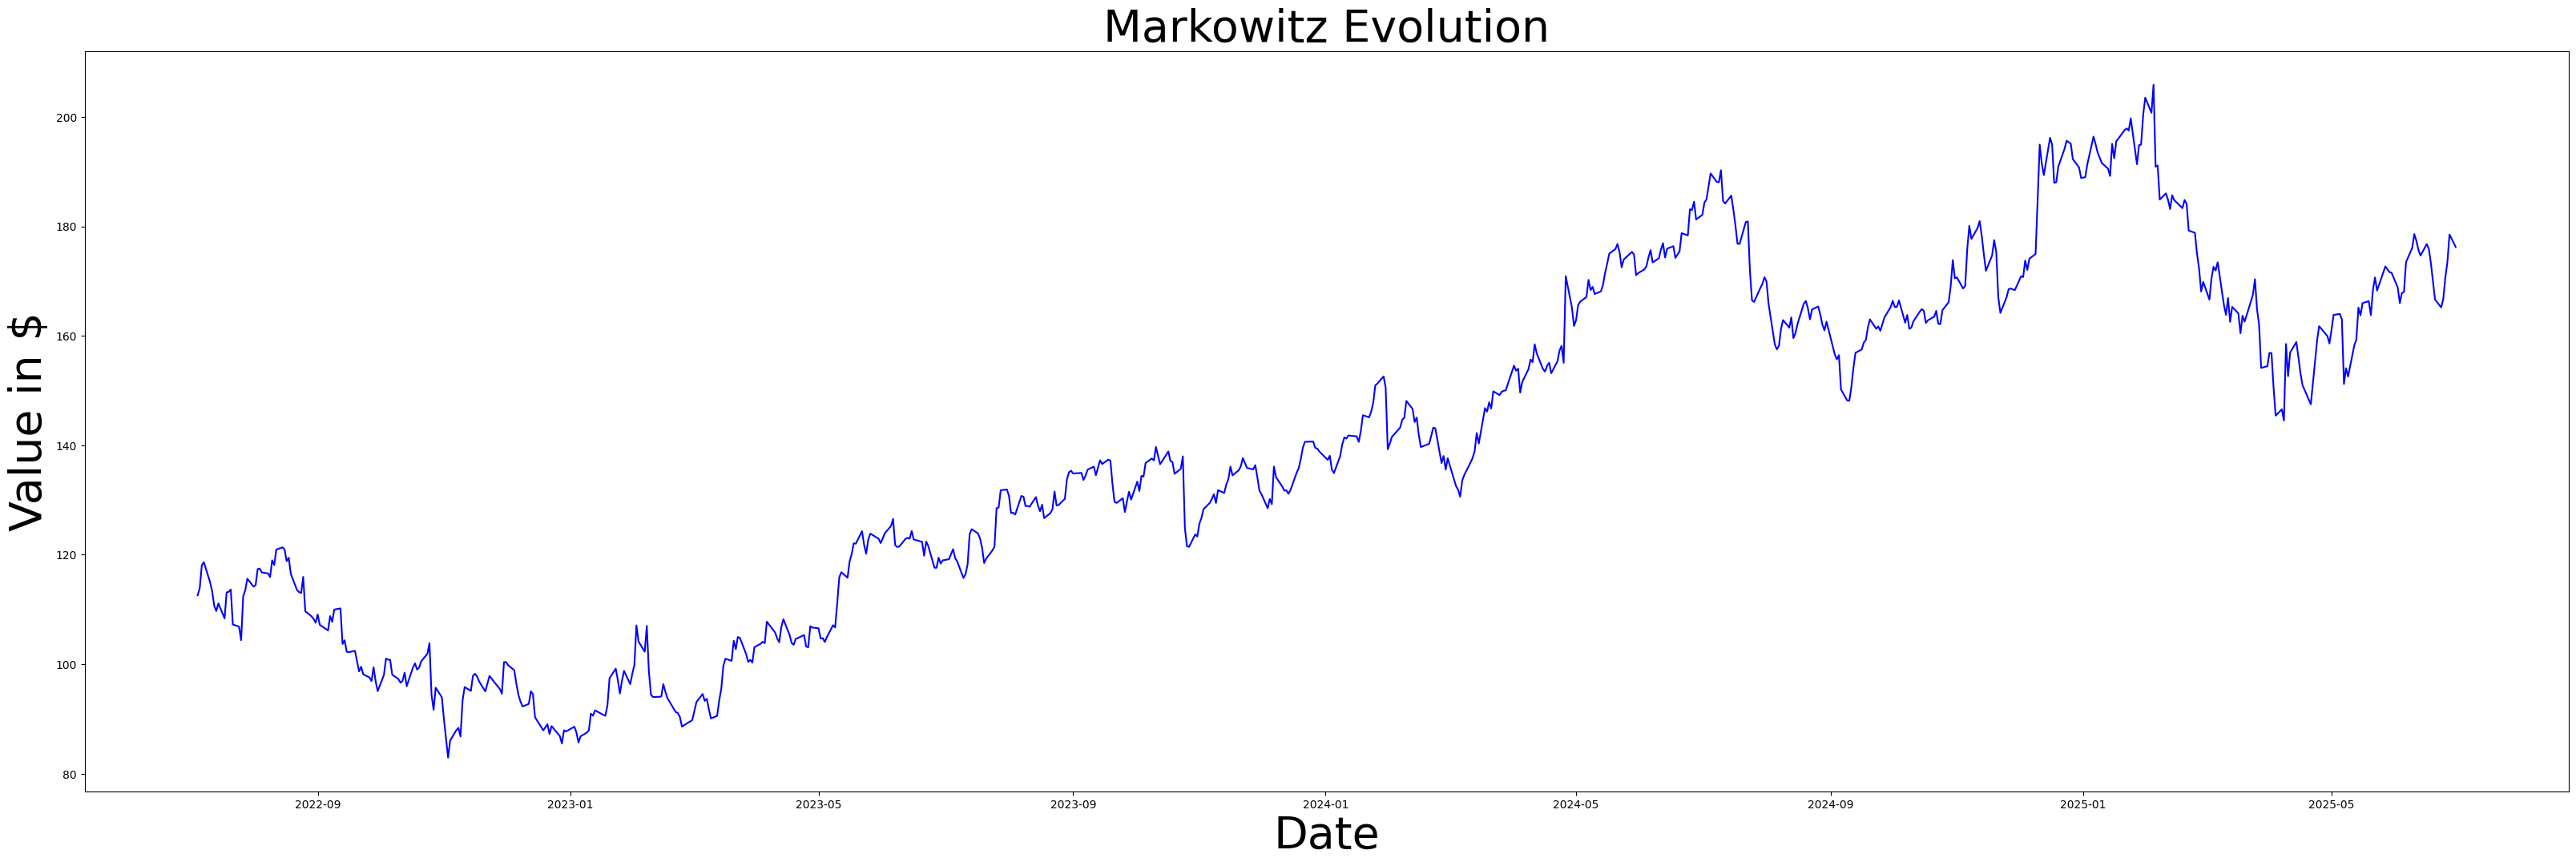

Total Return: 56.53%


In [62]:

markowitz_value, markowitz_return = analyzer.analyze_strategy('Markowitz', markowitz_data['optimal_weight'].x, PORTFOLIO_EVOLUTION_YEARS)
plot_portfolio_evolution(markowitz_value, "Markowitz Evolution")
print(f"Total Return: {markowitz_return:.2%}")


## Step 13: Final Strategy Recommendation

We compare the total returns from all strategies and select the one with the highest return.
The corresponding allocation and visualizations are displayed as a recommendation to the user.

In [63]:

best_strategy, best_return = analyzer.get_best_strategy()
print(f"Best Strategy: {best_strategy} with return {best_return:.2%}")


Best Strategy: Sharp Ratio with return 93.72%


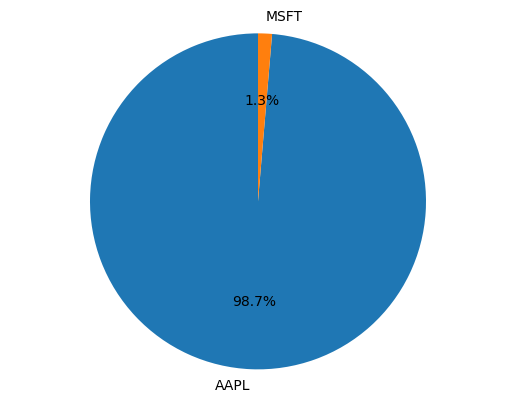

,Key,Value
0,AAPL,0.982795
1,MSFT,0.013320
2,GOOGL,0.003885


In [64]:

# Display corresponding pie chart and weights
if best_strategy == 'Risk Parity':
    create_pie_chart(risk_parity_weights, tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, risk_parity_weights)
elif best_strategy == 'Markowitz':
    create_pie_chart(markowitz_data['optimal_weight'].x, tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, markowitz_data['optimal_weight'].x)
elif best_strategy == 'User':
    create_pie_chart(weights, tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, weights)
elif best_strategy == 'Beta':
    create_pie_chart(beta_weight, tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, beta_weight)
elif best_strategy == 'Sharp Ratio':
    create_pie_chart(sharpe_data['sharpratio_weight'], tickers)
    df = analyzer.create_recommendation_dataframe(best_strategy, sharpe_data['sharpratio_weight'])

df
